# How we can predict melting point of a drug !

## ► Melting point
The process of a solid turning into a liquid state is called melting. It is also known as fusion. The reverse process of a liquid becoming a solid, is in turn called solidification. 
    "The temperature at which a solid substance melts and transforms into a liquid at atmospheric pressure is termed the melting point of a substance."    
* ref- https://www.geeksforgeeks.org/what-is-a-melting-point/


## ► Importing all packages and library

### Importing BeautifulSoup from bs4:
BeautifulSoup will use for recognize or fetching the HTML tags in a webpage online, and get the data from a website. like DrugBank database. In this beautiful soup we can identifing the tags from their id and class name. 
for more- https://beautiful-soup-4.readthedocs.io/en/latest/
    
### Importing requests:
requests is a python library thats allows to send a request to server and gets a response in the form of information like documents webpage.

In [3]:
import csv
import os
import requests
from bs4 import BeautifulSoup

## ► Collecting and fetching data

### Reading all Drug Bank id from a csv file

Just, create a empty list name as **drugID** for loaded id's from 'rough.csv' file (raw_data/rough.csv), rough.csv file created by the annotation of pubchem data which is in the form of XML and change it to csv from MS EXCEL. This annotation XML file is also present in the folder fo 'raw_data'.
For now we are use here only 100 data point for basic prediction. from 100 to 200 of index from **drugID** list.

In [ ]:
drugID = []
with open("raw_data/rough.csv", 'r') as csvf:
    for i in csv.reader(csvf):
        drugID.append(i[0])
drugID[100:200]

### Mining drug information from Drug Bank id

Making a class **drug_info()** for retrieving information like; smiles, molecular weight, melting point etc. basically **drug_detail()** method fetched all the information, which is stored in the *'dl'* and *'dt'* tags in the HTML code of perticular Drug bank page. So we could try to find only smile of compounds and molecular weight at a time.

In [ ]:
class drug_info():

    def __init__(self, drugBank_ID, feature_='html'):
        self.id = drugBank_ID
        self.feature = feature_

    def drug_detail(self):
        try:
            url = 'https://go.drugbank.com/drugs/%s' %self.id
            soup = BeautifulSoup(requests.get(url).text, self.feature)
            (key_lis, value_lis) = ([], [])
            for dt, dd in zip(soup.select('.card-content dl dt'), soup.select('.card-content dl dd')):
                key_lis.append(dt.string)
                value_lis.append(dd.string)
    
            data = {key_lis[i]: value_lis[i] for i in range(len(key_lis))}
            return data
        except:
            return 'connection error!'
    
    def smile(self):
        try:
            data = self.drug_detail()
            return data['SMILES']  # type: ignore
        except:
            pass
        
    def mol_Wight(self):
        try:
            data = self.drug_detail()
            return data['Molecular Weight']   # type: ignore
        except:
            pass
        
smiles = []
for did in drugID[100:105]:
    smiles.append(drug_info(did).smile())
# print(drug_info('DB00160').drug_detail())
smiles

In [10]:
smiles
with open('smile.txt', 'a') as wt:
    for line in smiles:
        wt.write(line)
        wt.write('\n')

In [ ]:
mol_weight = []
for idrug in drugID[100:200]:
    mol_weight.append(drug_info(idrug).mol_Wight())
print(mol_weight)

In [4]:
# type conversion
def typefloat(StrType):
    try:
        return float(StrType)
    except:
        pass
typefloat('55492.07')

55492.07

In [27]:
def chem_property(drug_id, feature_='html'):
    '''Search for drugs property by drug id from drug bank database
    drug property contains:- melting point, water solubility, logP etc...'''

    url = f'https://go.drugbank.com/drugs/{drug_id}'
    soup = BeautifulSoup(requests.get(url).text, feature_)
    (_list, propertes) = ([], [])
    for dd in soup.find('table', {'id': 'experimental-properties'}): # type: ignore 
        _list.append(dd)  # type: ignore
        
    soup = BeautifulSoup(f'''{_list[1]}''', 'html')
    for text in soup.find_all('td'):
        propertes.append(text.get_text())
    
    return [propertes[i:i+3] for i in range(0,len(propertes),3)]

chem_property('DB00178')

[['melting point (°C)', '109 °C', 'PhysProp'],
 ['water solubility', '3.5mg/L', 'Not Available'],
 ['logP', '2.9', 'Not Available']]

In [ ]:
melting_point = []
for d_id in drugID[100:200]:
    for element in chem_property(d_id):
        if element[0] == 'melting point (°C)':
            melting_point.append(element[1])

melting_point # type: ignore

In [ ]:
smiles = []
with open('smile.txt', 'r') as file:
    for line in file.readlines():
        smiles.append(line)

# ############# find and count Data ############### #

count_d_bond_t_bond_C_no_molw = []
for smile, molw in zip(smiles, mol_weight):
    count_ = []
    for character in ['=', '@', 'C']:  # count each double triple bond and number of carbons respectively
        count_.append(smile[:-1].count(character))  # smile[:-1] is use for remove or drop new lines
    try:
        count_.append(typefloat(molw[:-3]))
    except TypeError:
        count_.append(None)
    count_d_bond_t_bond_C_no_molw.append(count_)
count_d_bond_t_bond_C_no_molw

In [88]:
with open('MP_dataset_100_point.csv', 'w', newline='') as writeCSV:
    writer = csv.writer(writeCSV)
    writer.writerow(['double bonds', 'triple bonds', 'carbon numbers', 'molecular weight'])
    writer.writerows(count_d_bond_t_bond_C_no_molw)

## ► Data Preprocessing

Data preprocessing is a data mining technique which is used to transform the raw data into a useful and efficient format. I've use here *Normalization* and *Standardization* with mean standard diviation. 
normalization and standardization is the process of data transformation(this stepis taken in the order to transform the data in appropirate forms suitable for processing.)
for more- https://www.geeksforgeeks.org/data-preprocessing-in-data-mining/amp/ 

In [5]:
class statistics():
    """
    statistics class function is use for the performing basic task about, finding mean or the avg. value of set, variance,
    median and standard deviation.
    """
    def __init__(self, x_set):
        self.x = x_set
        self.N = len(x_set)

    def mean(self):
        summation = 0.0
        for element in self.x:
            summation += element
        return summation/float(self.N)
    
    def standard_dev(self):
        mean = self.mean()
        sumation = 0.0
        for i in self.x:
            sumation += (i - mean)**2
        return (sumation/self.N)**0.5


class pre_processing():
    '''pre processing class is use for feature engineering, creating the features and labels, 
    the problem of converting raw data to a dataset which can be
    read by machine is called feature engineering.'''

    def __init__(self, x_i):
        self.x = x_i

    def standardization(self):
        standardize = []
        mean = statistics(self.x).mean()
        dev = statistics(self.x).standard_dev()
        for j in self.x:
            standardize.append((j - mean)/dev)
        return standardize

    def normalization(self):
        normalize = []
        (min_j, max_j) = (min(self.x), max(self.x))
        for j in self.x:
            normalize.append((j - min_j)/(max_j - min_j))
        return normalize

    def imputation(self):
        return (1/float(len(self.x)))*sum(self.x)

pre_processing([4.00, 11.00, 28.00, 52963.03]).standardization()

[-0.577800924185601,
 -0.5774956134341787,
 -0.5767541444664385,
 1.732050682086218]

In [5]:
(data_row1, data_row2, data_row3, data_row4) = ([], [], [], [])
with open('MP_dataset_100_point.csv', 'r') as rdfile:
    for line in csv.reader(rdfile):
        data_row1.append(typefloat(line[0]))
        data_row2.append(typefloat(line[1]))
        data_row3.append(typefloat(line[2]))
        data_row4.append(typefloat(line[3]))

# pre_processing(data_row1[1:]).normalization()
print(data_row1, data_row2, data_row3, data_row4)

[None, 4.0, 2.0, 1.0, 9.0, 1.0, 1.0, 5.0, 3.0, 3.0, 1.0, 1.0, 6.0, 3.0, 6.0, 7.0, 1.0, 4.0, 2.0, 4.0, 4.0, 10.0, 6.0, 6.0, 4.0, 4.0, 3.0, 14.0, 3.0, 0.0, 8.0, 8.0, 4.0, 3.0, 7.0, 3.0, 3.0, 7.0, 8.0, 2.0, 4.0, 9.0, 6.0, 9.0, 1.0, 5.0, 9.0, 4.0, 8.0, 9.0, 6.0, 4.0, 6.0, 4.0, 8.0, 9.0, 11.0, 1.0, 4.0, 0.0, 1.0, 8.0, 7.0, 4.0, 6.0, 6.0, 2.0, 3.0, 7.0, 4.0, 4.0, 7.0, 4.0, 6.0, 8.0, 6.0, 7.0, 3.0, 8.0, 8.0, 8.0, 3.0, 8.0, 7.0, 9.0, 11.0, 2.0, 5.0, 1.0, 2.0, 7.0, 3.0, 5.0, 10.0, 4.0, 10.0, 8.0, 6.0, 2.0, 2.0, 11.0] [None, 11.0, 2.0, 3.0, 13.0, 1.0, 1.0, 0.0, 5.0, 0.0, 2.0, 2.0, 3.0, 9.0, 0.0, 6.0, 2.0, 0.0, 2.0, 12.0, 0.0, 2.0, 8.0, 3.0, 14.0, 0.0, 0.0, 6.0, 1.0, 2.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 26.0, 0.0, 0.0, 0.0, 10.0, 26.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 8.0, 2.0, 9.0, 0.0, 13.0, 0.0, 1.0, 0.0, 0.0, 0.0, 3.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 0.0, 0.0, 4.0, 0.0, 3.0, 5.0, 4.0, 0.0, 3.0, 0.0, 12.0, 9.0, 0.0, 9.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [58]:
met = [['a','b','c','d', 2, 4],
       ['e','f','g','h', 3, 3],
       ['i','j','k','l', 4, 2],
       ['m','n','o','p', 5, 1],
       ['q','r','s','t', 6, 0]]

def transform(mtrix):
    transf = []
    for i in range(len(mtrix[0])):
        lisr = []
        for j in range(len(mtrix)):
            lisr.append(mtrix[j][i])
        transf.append(lisr)
    return transf

transform(met)

[['a', 'e', 'i', 'm', 'q'],
 ['b', 'f', 'j', 'n', 'r'],
 ['c', 'g', 'k', 'o', 's'],
 ['d', 'h', 'l', 'p', 't'],
 [2, 3, 4, 5, 6],
 [4, 3, 2, 1, 0]]

In [7]:
dataset = (data_row1, data_row2, data_row3, data_row4)
preprocess = []
for row in dataset:
    preprocess.append(pre_processing(row[1:]).normalization())

preprocessed_dataset = transform(preprocess)

with open('processed_datasetMP.csv', 'w', newline='') as writefile:
    writable = csv.writer(writefile)
    writable.writerows(preprocessed_dataset)

In [ ]:
stri = 'about 848.5-856.4 °C (in HCl)'
def text_removal(string):
    only_dataPoint = ''
    for i in string:
        if i.isdigit():
            only_dataPoint+=i
        elif i in ['-', '.', '>', '<', '~']: only_dataPoint+=i
    return only_dataPoint
        
def arth_mean(a, *b):
    divd = 0
    count = 0
    for i in b:
        divd+=i
        count += 1
    return divd/count+1
    
def MEDIAN(a, b):
    ranges = []
    for i in range(a, b+1):
        ranges.append(i)
    n = len(ranges)
    if (n%2) == 0:
        sterm = (n/2)+1
        return ranges[int((n/2+sterm)/2)]
    else: return ranges[int((n+1)/2)]

def check_Minus(s):
    split = s.split('-')[0]
    if split == '':
        return True
    else: 
        return False
    
class accuracy_processing:
    def range_median(self, strig):    
        val1_val2 = strig.split('-')
        return MEDIAN(int(typefloat(val1_val2[0])), int(typefloat(val1_val2[1])))
    
    def symbolic_evaluation(self, strig, by_evaluate=8):
        if '<' in strig:
            val = typefloat(strig[1:])
            return val-by_evaluate
        elif '>' in strig:
            val = typefloat(strig[1:])
            return val+by_evaluate
        elif '~' in strig:
            val = typefloat(strig[1:])
            return val
        else: return typefloat(strig)


melting = []
with open('melting_point.csv', 'r') as file:
    for row in csv.reader(file):
        melting.append(typefloat(row[0]))

preprocessed_melting = pre_processing(melting).normalization()
preprocessed_melting

In [12]:
with open('melting_point.csv', 'w', newline='') as file:
    write = csv.writer(file)
    rows = zip(preprocessed_melting, drugID[100:200])
    for row in rows:
        write.writerow(row)

## ► Apply linear regression

In [2]:
class load_csv():
    """
    class contain many types of methods which use to read data.
    by load_csv([PATH_OF_FILE]).dataset(column, upto[row]) also read dataset and seperate feature and lable
    through load_csv([PATH_OF_FILE]).featured_dataset(upto[rows]), can also use top function(upto), and tail(upto) function
    rows upto you are selected
    """
    # specifying path by init
    def __init__(self, file_path):
        self.file = file_path

    # display dataset by two arguments column and upto
    # column = all ----- for represent all the column take's only all, and other's integer
    # upto = all ------- for representing all the data of a csv file, row also take's only all, and other's integer
    def dataset(self, column='all', upto='all'):
        '''read dataset with column number and upto rows number by default it's set on the all column 
        and all rows, but we can use number of column and rows'''
        try:
            # step to store data in row list variable
            rows = []
            # creating a function for converting string to floating point for allowing machine readable
            def float_type(point):
                floats = []
                try:
                    # converting each itration to floats
                    for i in point:
                        floats.append(float(i))
                except ValueError:
                    # except pass value error 
                    pass
                return floats

            # float converting each point not including j-dimension
            def float_type_each(point):
                try:
                    floats = float(point)
                    return floats
                except ValueError:
                    pass
                

            # open file and manipulate as csvf instance
            with open(self.file, 'r') as csvf:
                for row in csv.reader(csvf):
                    # check if all column is se
                    # print all row 
                    if column == 'all':
                        rows.append([i for i in float_type(row[:])])
                    else:
                        # else print a single particular column
                        rows.append(float_type_each(row[column]))
                # close the csv file
                csvf.close()
            # check if upto selected all
            # it's return all row
            if upto == 'all':
                return rows[:]
            else:
                # else return row upto, where you are selected
                return rows[:upto+1]
        except IndexError:
            # return error if you are selected wrong column
            return f"column {column} not exist in your dataset"
    
    def featured_dataset(self, upto='all'):
        '''featured dataset is allow to split features and lable returns two value one is feature and second is
        lable with arguments of rows'''
        try:
            # making empty to store feature in rows and lables in lable list
            feature = []
            lable = []
            def float_type(point):
                floats = []
                try:
                    for i in point:
                        floats.append(float(i))
                except ValueError:
                    pass
                return floats

            # open file and manipulate as csvf instance
            with open(self.file, 'r') as csvf:
                for row in csv.reader(csvf):
                     
                    # print all row 
                    # select all column except last most..
                    feature.append([i for i in float_type(row[:-1])])
                    # last column is selected as lables
                    lable.append(row[-1])
                # close the csv file
                csvf.close()
            # check if upto selected all
            # it's return all row
            if upto == 'all':
                return feature[1:], lable[1:]
            else:
                # else return row upto, where you are selected
                return feature[1:upto+1], lable[1:upto+1] 
        except IndexError:
            # return error if you are selected wrong column or row
            return "unexpected column/row in your dataset"

    def top(self, upto):
        '''function use for read top of the data upto desired rows'''
        select = self.dataset()
        return select[:upto]

    # this is same from above fuction but, it's use to read data rows from downward side (tail)
    def tail(self, upto):
        '''returns last most desired data points thsts, take argument as upto[rows]'''
        select = self.dataset()
        # -upto: is use for last point in list to be read upto ....
        return select[-upto:]

    def text_csv(self, upto='all'):
        '''To use for loading text data, if csv have text, character data which is exactly a string type
        load_csv(PATH_OF_FILE).text_csv(upto[rows])'''
        try:
            feature = []
            lable = []
            with open(self.file, 'r') as csvf:
                for row in csv.reader(csvf):
                    # print all row 
                    # select all column except last most..
                    feature.append(row[:-1])
                    # last column is selected as lables
                    lable.append(row[-1])
                # close the csv file
                csvf.close()
                # check if upto selected all
                # it's return all row
            if upto == 'all':
                return feature[1:], lable[1:]
            else:
                # else return row upto, where you are selected
                return feature[1:upto+1], lable[1:upto+1]
        except IndexError:
            # return error if you are selected wrong column or row
            return "unexpected column/row in your dataset"

def datasetLoader(path, cols='all'):
    Xdataset = []
    def float_type(point):
        floats = []
        try:
            # converting each itration to floats
            for i in point:
                  floats.append(float(i))
        except ValueError:
            # except pass value error 
            pass
        return floats
    
    with open(path, 'r') as rfile:
        for row in csv.reader(rfile):
            if cols != 'all':
                Xdataset.append(float_type(row[:cols]))
            else:
                Xdataset.append(float_type(row[:]))
    return Xdataset

In [6]:
def concatenate(met_a, met_b, axis):
    e = []
    if axis == 1:
        for i, j in zip(met_a, met_b):
            e.append(i+j)
        return e
    elif axis == 0:
        return met_a+met_b

def shape(metrix):
    (cols, rows) = (0, 0)
    for i in metrix:
        rows+=1
    for j in metrix[0]:
        cols+=1
    return (rows, cols)

def ones(shape, multiply=1.0, type=float, metrixShape=1):
    metrix = []
    for r in range(shape[0]):
        cols = []
        for c in range(shape[1]):
            if type == int:
                cols.append(int(1.*multiply))
            else: cols.append(1.*multiply)
        metrix.append(cols)
    return metrix*metrixShape

def ones1D(num, multiply=1.0, type=float):
    met = []
    for i in range(num):
        if type == int:
            met.append(int(1.*multiply))
        else: met.append(1.*multiply)
    return met

def dot1D_2D(A, B):
    return [sum(i*j for i,j in zip(row, B)) for row in A]

In [7]:
def train_multivariate_model(X, y, epoch, lr=0.001):
    m = shape(X)[0] 
    one_met = ones((m, 1))

    X = concatenate(one_met, X, axis=1)
    n = shape(X)[1]
    theta = ones1D(n)
    hypothesis = dot1D_2D(X, theta)
    cost = ones1D(epoch)
    for i in range(0, epoch):
        # print(shape(X), theta[0])
        theta[0]=theta[0]-(lr/shape(X)[0])*sum([h-y_ for h, y_ in zip(hypothesis, y)])
        for j in range(1, n):
            # print('j: ', theta[j], X)
            theta[j]=theta[j]-(lr/shape(X)[0])*sum([(h-y_)*X[i][j] for h, y_ in zip(hypothesis, y)])
            # print('j af.: ', j)
        hypothesis = dot1D_2D(X, theta)
        cost[i]=1/(2*m)*sum([(h-y_)**2 for h, y_ in zip(hypothesis, y)])
    
    return cost, theta

In [6]:
class LinearRegression():

    def linear_prediction(self, x_i, w_i, b):
        return w_i*x_i + b

    def multivariate_prediction(self, X, W):
        wx = 0.0
        W_ = W[1:]
        for i in range(len(X)):
            wx += X[i]*W_[i]
        return wx

[0.8553742447834787, 0.9464621109465955, 0.9844042304532041, 0.9452978042026191, 0.9589162696694389]


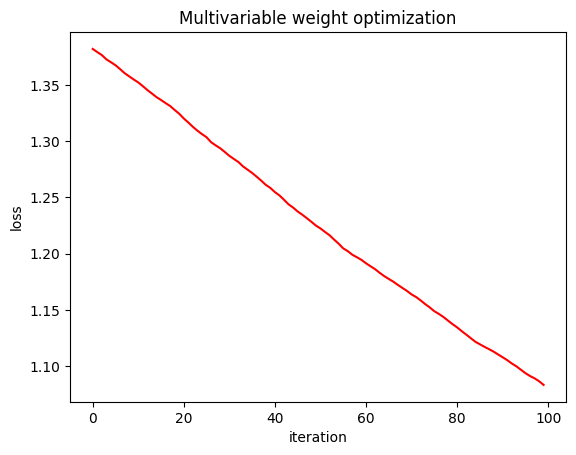

In [11]:
# training model...
import matplotlib.pyplot as plt
preprocessed_file = 'processed_datasetMP.csv' # 'MP_dataset_100_point.csv' 'A:/BIOINFORMAICS/ML-Training-main/11-Linear-Regression/USA_Housing.csv'

X = datasetLoader(preprocessed_file, cols=4)
Y = load_csv(preprocessed_file).dataset(column=5)

epoch = 100
training = train_multivariate_model(X[:epoch], Y[:epoch], epoch, lr=0.001)  # bais and weight has been initialize with 1.0

iteration = [i for i in range(epoch)]

plt.plot(iteration, training[0], 'r')
plt.title('Multivariable weight optimization')
plt.xlabel('iteration')
plt.ylabel('loss')

print(training[1])
# for i in training[0]:
#    print(i)

Xnew1 = [0.5,0,0.6,0.204527913]
Xnew2 = [0.285714286,0.153846154,0.228571429,0.262746687]
# LinearRegression().multivariate_prediction(Xnew1, training[1])

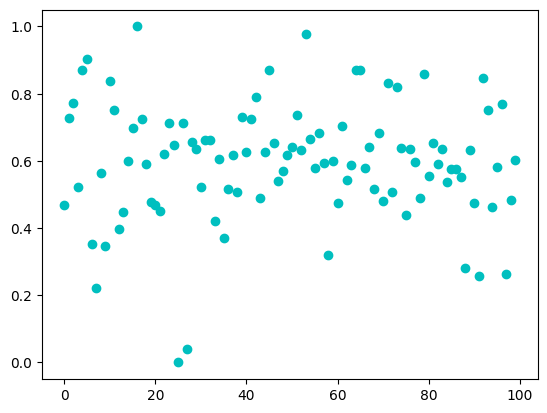

In [9]:
plt.scatter(iteration, Y, c='c')